# App

In [1]:
from app import app

In [2]:
app.run_server(debug=True, port=8000)

# Data
*create data for pages*

In [6]:
import pandas as pd
import os

In [7]:
os.chdir('/home/lbk/works/pf')

In [8]:
from pf_utils import PortfolioManager as PM 

In [9]:
path_data = 'data'
path_tran = 'transaction'

In [10]:
file_cost='transaction_cost'

## Price

In [11]:
universe = 'UV_FNDM'
fund = PM.create_universe(universe)
cost = PM.get_cost(universe, file=file_cost, path=path_tran)
fee = cost['fee']

252 securities from 2005-01-31 to 2025-03-31 uploaded.
Data for 252 funds loaded.
Price data loaded
Cost data transaction_cost_250409.csv loaded


In [12]:
df_prices = fund.df_prices
df_prices_fees = fund._get_prices_after_fee(df_prices, fee)

In [13]:
cols = ['price', 'price_after_fees']

df_prc = df_prices[df_prices.index.is_month_end].unstack().to_frame(cols[0])
df = df_prices_fees[df_prices_fees.index.is_month_end].unstack().rename(cols[1])
df_all = df_prc.join(df).rename_axis(['ticker', 'date']).dropna().round(1)
df_all

price  price_after_fees
ticker       date                                
K55234DF2657 2021-04-30  1009.8            1008.8
             2021-05-31  1017.7            1016.7
             2021-06-30  1031.9            1030.9
             2021-08-31  1063.8            1061.7
             2021-09-30  1049.1            1047.0
...                         ...               ...
K55234E28379 2024-10-31  1028.6            1027.2
             2024-12-31  1034.3            1032.9
             2025-01-31  1037.1            1035.5
             2025-02-28  1039.6            1038.0
             2025-03-31  1042.3            1040.7

[14481 rows x 2 columns]

In [14]:
df_all.index.get_level_values(0).nunique()

252

In [15]:
date = df_all.index.get_level_values('date').max().strftime('%y%m%d')
date

'250331'

In [16]:
file = f'funds_monthly_{date}.csv'
path = 'pages'
df_all.to_csv(f'{path}/{file}')

## Category

In [17]:
file = 'funds_categories.csv'
path = 'data'

In [18]:
!cp {path}/{file} pages 

In [19]:
df_cat = pd.read_csv(f'{path}/{file}').set_index('ticker')
df_cat.columns

Index(['name', 'seller', 'account', 'manager', 'asset', 'strategy', 'region'], dtype='object')

In [20]:
len(df_cat)

252

## Bayesian

In [21]:
from pf_dash import get_hdi

file = 'fund_f3y_s5y'
path = 'data'
df_est = get_hdi(file, path, to_dict=False)
df_est.head()

fund_f3y_s5y.pkl* loaded


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ticker,,,,,,,,,
KR5102314204,0.066,0.062,-0.045,0.183,0.001,0.001,10311.0,2345.0,1.01
KR5102314352,0.058,0.060,-0.053,0.169,0.001,0.001,9759.0,2857.0,1.00
KR5102314212,0.100,0.259,-0.394,0.571,0.003,0.005,9309.0,2717.0,1.00
KR5101753360,0.182,0.253,-0.299,0.673,0.002,0.004,10647.0,2713.0,1.00
KR5234769887,0.072,0.361,-0.599,0.747,0.004,0.006,8425.0,2838.0,1.00


In [22]:
len(df_est)

189

In [23]:
file = 'funds_bayesian_ret3y_250409.csv'
path = 'pages'
df_est.to_csv(f'{path}/{file}')

*get back to pages*

In [24]:
os.chdir('pages')

# Deploy

In [ ]:
if __name__ == '__main__':
    app.run_server(debug=True)

## Implement

In [5]:
from dash import Dash, html, dcc, Output, Input, State
import pandas as pd
import dash_bootstrap_components as dbc
import dash_daq as daq
import json
from ddf_utils import break_line, extract_topics
from contents_info import info

external_stylesheets = [dbc.themes.CERULEAN, 
                        #dbc.themes.BOOTSTRAP,
                        dbc.icons.FONT_AWESOME,
                        dbc.icons.BOOTSTRAP]

style_heading={'color':'slategray', 'font-weight':'bold'}

default_group = '자산'
base_prc = 1000
date_format = '%Y-%m-%d'
months_in_year = 12
cols_prc = {
    'price': '수수료 적용 전', 
    'price_after_fees': '수수료 적용 후'
}
category = {
    'name': '펀드',
    'seller': '판매',
    'account': '계좌',
    'manager': '운용',
    'asset': '자산',
    'strategy': '전략',
    'region': '지역'
}

# data to import
dt = '250228'
file_prc = f'funds_monthly_{dt}.csv'
file_cat = 'funds_categories.csv'
file_est = 'funds_bayesian_ret3y_250228.csv'
path = '.'

# Load data
## price
df_prc = pd.read_csv(
    f'{path}/{file_prc}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['ticker', 'date']
)
df_prc.columns = [cols_prc[x] for x in df_prc.columns]

## cateory
df_cat = pd.read_csv(f'{path}/{file_cat}', index_col=['ticker'])

## beysian stats
df_est = pd.read_csv(f'{path}/{file_est}', index_col=['ticker'])

# Preprocess data to JSON-serializable
## category
data_cat = dict()
for col in df_cat.columns:
    data_cat[col] = df_cat[col].reset_index().groupby(col)['ticker'].apply(list).to_dict()

## name for plots
data_name = df_cat['name'].to_dict()

## price
data_prc = {}
for col in df_prc.columns:
    df = df_prc[col].unstack('ticker').sort_index().dropna(how='all')
    df = df.reindex(df.index.strftime(date_format))
    data_prc[col] = {x: df[x].dropna().to_dict() for x in df.columns}
    #data_prc[col] = df.to_dict(orient='dict')

## Scatter of estimations
xlabel, ylabel = 'mean', 'sd'
df_s = df_est.apply(lambda x: x[xlabel]/ x[ylabel], axis=1).rank().rename('sharpe')
data_est = df_est.join(df_s).join(df_cat)
# convert mean/sd into respective ranks
data_est[xlabel] = data_est[xlabel].rank(ascending=False, pct=True).mul(100)
data_est[ylabel] = data_est[ylabel].rank(pct=True).mul(100)
cols = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'sharpe'] + df_cat.columns.to_list()
data_est = data_est[cols].to_dict()

## rank
data_rank = df_est['mean'].rank(ascending=False).to_dict()

# define dropdown options and default value
category_options = [{'label':category[x], 'value':x} for x in df_cat.columns]
category_default = 'asset'
group_default = ['All', '#Top10']

# additional group option for every cat
label = '이거어때?'
desc = '3년수익률 추정 평균/편차 순위 모두 상위권 펀드'
tickers = ['K55364CF7048', 'KR5235AK9808']
_ = [data_cat[x].update({label:tickers}) for x in data_cat.keys()]
data_title = {label: desc} # define option title other than label for group options

### init Dash

In [9]:
# convert data to json
data_cat_json = json.dumps(data_cat)
data_name_json = json.dumps(data_name)
data_prc_json = json.dumps(data_prc)
data_est_json = json.dumps(data_est)
data_rank_json = json.dumps(data_rank)
data_title_json = json.dumps(data_title)

app = Dash(__name__, title="달달펀드",
           external_stylesheets=external_stylesheets)

app.index_string = f"""
<!DOCTYPE html>
<html>
    <head>
        {{%metas%}}
        <title>{{%title%}}</title>
        <link rel="icon" type="image/x-icon" href="/assets/favicon.ico">
        {{%css%}}
    </head>
    <body>
        <script>
            var dataCategory = {data_cat_json};
            var dataName = {data_name_json};
            var dataPrice = {data_prc_json};
            var dataScatter = {data_est_json};
            var dataRank = {data_rank_json}
            var dataTitle = {data_title_json};
        </script>
        {{%app_entry%}}
        {{%config%}}
        {{%scripts%}}
        {{%renderer%}}
    </body>
</html>
"""

# footer
footer = html.Footer(
    html.Small([
    html.I(className="fa-regular fa-copyright"),
    '2025 달달펀드'
]), style={'textAlign': 'right', 'margin-top': '20px'})

# info
tab_info = html.Div([
    html.P(),
    html.P('다달이 전하는 펀드 투자 정보', style=style_heading),
    html.Div(break_line(info['about'], html.P), style={'line-height': '100%'}),
    html.Div([
        dbc.Alert([
            html.I(className="bi bi-info-circle-fill me-2"),
            info['disclaimer'],
            ],
            color="info",
            className="d-flex align-items-center",
        ),
        html.P([
            html.I(className="fa-regular fa-envelope", title='문의', style={"margin-right": "10px"}),
            html.A(info['email'], href=f"mailto:{info['email']}?Subject=달달펀드:문의")
        ], style={'textAlign': 'right'})
    ], style={'fontSize': 14})
    #])
])

# notice
tab_notice = html.Div(
    children=[
        dcc.Store(id="load-giscus", data=1),  # Trigger the clientside callback on initial load
        html.Div(className="giscus"),  # Placeholder for Giscus
    ]
    , style={'margin-top': '20px'}
)

# tabs
tabs_contents = [
    dbc.Tab(dcc.Graph(id='price-plot'), label='가격'),
    dbc.Tab(dcc.Graph(id='cagr-plot'), label='수익률', tab_id='tab_cagr'),
    dbc.Tab(dcc.Graph(id='scatter-plot'), label='순위', tab_id='tab_scatter'),
    dbc.Tab(tab_notice, label='알림',
            label_class_name="tab-label new-badge-label"),
    dbc.Tab(tab_info, label='정보', tab_id='tab_info')
]
tabs = dbc.Tabs(tabs_contents, id='tabs')


app.layout = dbc.Container([
    html.Br(),
    dbc.Stack([
        html.Div(
            dcc.Dropdown(
                id='category-dropdown',
                options=category_options,
                value=category_default,
                clearable=False,
            ), style={'min-width':'15%'}
        ),
        html.Div(
            dcc.Dropdown(
                id='group-dropdown',
                #options=groups,
                value=group_default,
                multi=True,
            ), style={'min-width':'55%', 'max-width':'100%'}
        ),
        daq.BooleanSwitch(
            id='compare-boolean-switch',
            on=False
        ),
        daq.BooleanSwitch(
            id='cost-boolean-switch',
            on=False
        ),
        dcc.Clipboard(
            id='ticker-copy',
            target_id="ticker-textarea",
            style={
                "display": "inline-block",
                "fontSize": 25,
                "color": "darkgray",  # Default icon color
                "cursor": "pointer",  # Pointer cursor for better UX
                #"verticalAlign": "bottom",
            },
        ),
    ],
        #justify="start", # horizondal
        #align="center", # vertical
        direction="horizontal",
        gap=2,
        className="mb-3"
    ),
    dbc.Row(tabs),
    dbc.Row(footer),
    html.Br(),
    dcc.Textarea(
        id="ticker-textarea",
        hidden='hidden', 
        #cols=50, rows=10
    ),
    dbc.Tooltip(
        '상대 비교',
        target='compare-boolean-switch',
        placement='bottom'
    ),
    dbc.Tooltip(
        '수수료 적용',
        target='cost-boolean-switch',
        placement='bottom'
    ),
    dbc.Tooltip(
        '펀드코드 복사',
        target='ticker-copy',
        placement='bottom'
    ),
    dcc.Store(id='ticker-data'),
    dcc.Store(id='name-data'),
    dcc.Store(id='price-data'),
    dcc.Store(id='scatter-data'),
    dcc.Location(id="url", refresh=False),  # To initialize the page
#], fluid=True)  # Full-width container
])

# update group options depending on category
app.clientside_callback(
    """
    function(category, groups_opt) {
        let obj = dataCategory[category];
        let groups = Object.keys(obj);
        let maxLength = 20; // Set max label length

        // Prepend "All" to the list
        let options = [
            { label: "All", value: "All", title: "전체 펀드" },
            { label: "#Top10", value: "#Top10", title: "3년 수익률 추정 평균 기준"},
            { label: "#Bottom10", value: "#Bottom10", title: "3년 수익률 추정 평균 기준"},
            { label: "#Random10", value: "#Random10", title: "3년 수익률 추정 평균 기준"},
        ];

        // Map over groups and append them to the list
        options = options.concat(
            groups.map(group => ({
                label: group.length > maxLength ? group.substring(0, maxLength) + "..." : group,
                value: group,
                title: dataTitle[group] || group  // Use group name if dataTitle[group] is missing
            }))
        );
        // reset group values to 'All' and ranking selected before
        groups_opt = groups_opt?.filter(group => group.startsWith('#')) || [];
        return [options, ['All', ...groups_opt]];
    }
    """,
    Output('group-dropdown', 'options'),
    Output('group-dropdown', 'value'),
    Input('category-dropdown', 'value'),
    State('group-dropdown', 'value')
)

# check group values with 'All' or ranking
app.clientside_callback(
    """
    function processGroups(groups) {
        // Split groups into `groups_m` (regular) and `groups_opt` (options)
        let { groups_m, group_opt } = (groups || []).reduce((acc, group) => {
            if (group.startsWith("#")) {
                acc.group_opt = group; // Keep only the latest rank option
            } else {
                acc.groups_m.push(group);
            }
            return acc;
        }, { groups_m: [], group_opt: null });

        //console.log(groups_m)
        //console.log(group_opt)

        // Check if 'All' is the last element
        if (groups_m.length === 0 || groups_m[groups_m.length - 1] === 'All') {
            return ['All', group_opt].filter(Boolean); // Remove null values
        };
    
        // If 'All' is in the array but not the last element, return without 'All'
        if (groups_m.includes('All')) {
            return groups_m.filter(group => group !== 'All').concat(group_opt).filter(Boolean);
        };
        
        // Otherwise, return the array with new rank option
        return groups_m.concat(group_opt).filter(Boolean);
    }
    """,
    Output('group-dropdown', 'value', allow_duplicate=True),
    Input('group-dropdown', 'value'),
    prevent_initial_call=True
)

# update tickers based on selected groups and category
app.clientside_callback(
    """
    function(groups, category) {
        let tickers = [];
        if (!groups || !category || !dataCategory[category]) return tickers;

        // If groups contain "All", return all tickers from the category
        if (groups.includes("All")) {
            tickers = Object.values(dataCategory[category]).flat();
        } else {
            // Otherwise, return tickers only for the specified groups
            groups.forEach(group => {
                if (dataCategory[category] && dataCategory[category][group]) {
                    tickers = tickers.concat(dataCategory[category][group]);
                }
            });
        };

        // filter tickers depending on the order in dataRank
        const groups_opt = groups?.filter(group => group.startsWith('#')) || [];
        if (groups_opt.length === 1) {
            const match = groups_opt[0].slice(1).match(/^([a-zA-Z]+)(\\d+)$/);
            tickers = selectTickers(match[1], tickers, dataRank, num=match[2])
            //tickers = selectTickers("Top", tickers, dataRank, num=10)
        };
        return tickers;
    }
    """,
    Output('ticker-data', 'data'),
    Input('group-dropdown', 'value'),
    State('category-dropdown', 'value')
)

# save name and ticker of funds for copying
app.clientside_callback(
    """
    function(tickers) {
        let result = Object.entries(dataName)
                     .filter(([k, v]) => tickers.includes(k)) // check if k is in tickers
                     .map(([k, v]) => `${k}: ${v}`);
        return result.join('\\n');
    }
    """,
    Output('ticker-textarea', 'value'),
    Input('ticker-data', 'data'),
)

# update price data based on selected tickers
app.clientside_callback(
    """
    function(tickers) {
        if (!tickers || tickers.length === 0) return {};
        
        let data_prc_tkr = {};
        for (let fee in dataPrice) {
            data_prc_tkr[fee] = {};
            for (let tkr in dataPrice[fee]) {
                if (tickers.includes(tkr)) {
                    data_prc_tkr[fee][tkr] = dataPrice[fee][tkr];
                }
            }
        }
        return data_prc_tkr;
    }
    """,
    Output('price-data', 'data'),
    Input('ticker-data', 'data')
)

# plot price history
app.clientside_callback(
    """
    function(data, cost, compare) {
        if (!data || Object.keys(data).length === 0) {
            return { data: [], layout: {} };  // Empty plot
        }
        
        let fees = Object.keys(data);
        let fee = cost ? fees[1] : fees[0];

        if (!data[fee]) {
            return { data: [], layout: {} };
        }

        let df = data[fee];
        if (compare) {
            df = normalizePrice(df, 1000);
        }
        let traces = [];

        for (let tkr in df) {
            traces.push({
                x: Object.keys(df[tkr]),  // Assuming keys are dates
                y: Object.values(df[tkr]).map(val => Math.round(val)),  // Assuming values are prices
                type: 'scatter',
                mode: 'lines',
                name: dataName[tkr]
            });
        }

        // Title logic
        const titleBase = '펀드 가격 추이';
        const titleComp = compare ? '상대 가격' : '펀드별 최근 결산 기준가격';
        const titleCost = cost ? '수수료 적용' : null;

        let title = `${titleBase} (${titleComp}`;
        title = titleCost ? `${title}, ${titleCost})` : `${title})`;

        let layout = {
            title: { text: title},
            hovermode: 'x',
            yaxis: { title: '가격' },
            xaxis: {
                rangeselector: {
                    buttons: [
                        {
                            count: 3,
                            label: "3y",
                            step: "year",
                            stepmode: "backward"
                        },
                        {
                            step: "all",
                            label: "All"
                        }
                    ]
                },
                type: "date"
            },
        }

        // Adjust legend position for mobile devices
        layout = updateLayout(layout, x = 0, y = -0.5, width = 768)
                
        return {
            data: traces,
            layout: layout
        };
    }
    """,
    Output('price-plot', 'figure'),
    Input('price-data', 'data'),
    Input('cost-boolean-switch', 'on'),
    Input('compare-boolean-switch', 'on'),
)


# plot bar chart of cagr
app.clientside_callback(
    """
    function(data, compare) {
        if (!data || Object.keys(data).length === 0) {
            return { data: [], layout: {} };
        }

        // calc CAGR
        let data_cagr = {};
        for (let fee in data) {
            let df = data[fee];
            if (compare) { // normalize depending on compare switch
                df = normalizePrice(df, 1000);
                let tickers = Object.keys(df);
                var dates = Object.keys(df[tickers[0]]);
                console.log(dates)
            };
            data_cagr[fee] = {};
            for (let tkr in df) {
                data_cagr[fee][tkr] = calculateCAGR(df[tkr]);
            }
        }

        let categories = Object.keys(data_cagr);
        let tickers = Object.keys(data_cagr[categories[0]]);
        
        let traces = categories.map(category => {
            return {
                x: tickers.map(tkr => dataName[tkr]),
                //y: tickers.map(tkr => data_cagr[category][tkr] || 0),
                y: tickers.map(tkr => Math.round((data_cagr[category][tkr] || 0) * 10) / 10), // Round to 1 decimals
                type: 'bar',
                name: category
            };
        });

        let title;
        if (compare) {
            const dt0 = new Date(Math.min(...dates.map(d => new Date(d).getTime()))).toISOString().slice(0, 10);
            const dt1 = new Date(Math.max(...dates.map(d => new Date(d).getTime()))).toISOString().slice(0, 10);
            title = `펀드 연평균 수익률 (${dt0} ~ ${dt1})`;
        } else {
            title = '펀드 연평균 수익률 (펀드별 설정일 이후)';
        };

        let layout = {
            title: {text: title},
            barmode: 'group',
            hovermode: 'x',
            //xaxis: { title: 'Ticker' },
            yaxis: { title: '연평균 수익률 (%)' }
        };

        // Adjust legend position for mobile devices
        layout = updateLayout(layout, x = 0, y = -0.5, width = 768)

        return { data: traces, layout: layout };
    }
    """,
    Output('cagr-plot', 'figure'),
    Input('price-data', 'data'),
    Input('compare-boolean-switch', 'on')
)

# update scatter data based on selected tickers
app.clientside_callback(
    """
    function(tickers) {
        if (!tickers || tickers.length === 0) return {};

        const filteredData = {};
        for (const key in dataScatter) {
            filteredData[key] = {};
            for (const ticker of tickers) {
              if (dataScatter[key][ticker] !== undefined) {
                filteredData[key][ticker] = dataScatter[key][ticker];
              }
            }
        }
        
        return filteredData;
    }
    """,
    Output('scatter-data', 'data'),
    Input('ticker-data', 'data')
)

# scatter plot of mean/sd of 3yr return estimations
app.clientside_callback(
    """
    function(data, category) {
        // Define the scale for marker size
        const scale_marker_size = 0.1;
        const add_marker_size = 5;
        
        // Custom color map
        const color_map = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'];

        // Get the keys (i.e., the unique identifiers) for the data
        const keys = Object.keys(data['mean']);

        // Filter the unique categories based on the selected category
        const unique_categories = [...new Set(keys.map(key => data[category][key]))];

        // Create a map for symbols to be assigned to each category
        const symbol_map = {};
        unique_categories.forEach((cat, i) => {
            symbol_map[cat] = i;
        });

        // Create traces for each category
        let traces = unique_categories.map((cat, i) => {
            // Filter data by the selected category
            const df_filtered = keys.filter(key => data[category][key] === cat);

            // Create the trace for each category
            return {
                x: df_filtered.map(key => data['mean'][key]),
                y: df_filtered.map(key => data['sd'][key]),
                customdata: df_filtered.map(key => [
                    data['name'][key], 
                    data['hdi_3%'][key], 
                    data['hdi_97%'][key]
                ]),
                mode: 'markers',
                marker: {
                    size: df_filtered.map(key => data['sharpe'][key] * scale_marker_size + add_marker_size),
                    color: color_map[i % color_map.length],  // Assign a unique color per category
                    symbol: df_filtered.map(key => symbol_map[data[category][key]])  // Assign a unique symbol per category
                },
                name: cat,  // Legend entry
                hovertemplate: '<span style=\"font-size: 120%;\">%{customdata[0]}</span><br>' +
                               '수익률 순위(%): 평균 %{x:.0f}, 편차 %{y:.0f}<br>' +
                               '수익률 구간: %{customdata[1]} ~ %{customdata[2]}<extra></extra>',
            };
        });

        // Define the reference line (y = x)
        const x_min = 1;
        const x_max = 100;
        const line_trace = {
            x: [x_min, x_max],
            y: [x_min, x_max],  // Slope 1 line (y = x)
            mode: 'lines',
            //line: { color: 'black', dash: 'dash' }, // Dashed black line
            line: { color: 'rgba(204, 204, 204, 0.5)', width: 1},
            showlegend: false
        };
    
        // Add the line trace to the traces array
        traces.push(line_trace);

        // Adding annotation
        var font = {size:30, weight:'bold', color:'rgba(204, 204, 204, 0.5)',
                    //family: 'Lucida Console, Courier, monospace'
                    }
        var ant1 = {x:70, y:30, showarrow:false, font:font, text:'안 정 성'};
        var ant2 = {x:30, y:70, showarrow:false, font:font, text:'수 익 성'};

        // Define layout
        let layout = {
            title: { text: '펀드 순위 (3년 수익률의 94% 확률 추정)' }, 
            xaxis: { title: '평균 %순위', autorange: 'reversed', zeroline:false},
            yaxis: { title: '편차 %순위', autorange: 'reversed', zeroline:false},
            annotations: [ant1, ant2],
            hovermode: 'closest',
            showlegend: true,
            legend: { title: category },
            //width: 600,
            height: 500,
        };

        // Adjust legend position for mobile devices
        layout = updateLayout(layout, x = 0, y = -0.5, width = 768)

        // Return the data for the figure
        return { data: traces, layout: layout };
    }
    """,
    Output('scatter-plot', 'figure'),
    Input('scatter-data', 'data'),
    Input('category-dropdown', 'value')
);

# contrain fee/compare switch depending on tabs
app.clientside_callback(
    """
    function(tab, cost, compare) {
        if (tab === "tab_scatter") {
            return [true, false, true, true];
        } else if (tab === "tab_info") {
            return [cost, compare, true, true];
        } else if (tab === "tab_cagr") {
            return [true, compare, true, false];
        } else {
            return [cost, compare, false, false];
        }
    }
    """,
    [Output('cost-boolean-switch', 'on'), Output('compare-boolean-switch', 'on'), 
     Output('cost-boolean-switch', 'disabled'), Output('compare-boolean-switch', 'disabled')],
    [Input("tabs", "active_tab"), Input('cost-boolean-switch', 'on'), Input('compare-boolean-switch', 'on')]
)

# contrain category/group dropdown depending on tabs
app.clientside_callback(
    """
    function(tab, category, group) {
        if (tab === "tab_info") {
            return [true, true];
        } else {
            return [false, false];
        }
    }
    """,
    Output('category-dropdown', 'disabled'), 
    Output('group-dropdown', 'disabled'),
    Input("tabs", "active_tab")
)

# Define clientside callback to load and initialize Giscus
app.clientside_callback(
    """
    function(data) {
        if (!data) return;  // Do nothing if data hasn't been triggered

        // Check if Giscus script is already loaded
        if (!document.querySelector('script[src="https://giscus.app/client.js"]')) {
            // Create the Giscus script element
            var script = document.createElement('script');
            script.src = "https://giscus.app/client.js";
            script.setAttribute("data-repo", "lbk209/fund");
            script.setAttribute("data-repo-id", "R_kgDONicCMA");
            script.setAttribute("data-category", "Announcements");
            script.setAttribute("data-category-id", "DIC_kwDONicCMM4Cluz9");
            script.setAttribute("data-mapping", "pathname");
            script.setAttribute("data-strict", "0");
            script.setAttribute("data-reactions-enabled", "1");
            script.setAttribute("data-emit-metadata", "0");
            script.setAttribute("data-input-position", "bottom");
            script.setAttribute("data-theme", "light");
            script.setAttribute("data-lang", "ko");
            script.setAttribute("crossorigin", "anonymous");
            script.async = true;

            // Append the script to the body
            document.body.appendChild(script);

            // Re-initialize Giscus when the script is loaded
            script.onload = function() {
                var event = new Event("giscus:reset");
                document.querySelector(".giscus").dispatchEvent(event);
            };
        } else {
            // If script is already loaded, just reset Giscus
            var event = new Event("giscus:reset");
            document.querySelector(".giscus").dispatchEvent(event);
        }

        return null;
    }
    """,
    Output("load-giscus", "data"),
    Input("load-giscus", "data"),
)

# Register the clientside callback to check if on mobile and apply label-style-mobile to all tabs
app.clientside_callback(
    """
    function(pathname) {
        // Check if the current window width indicates a mobile device
        const isMobile = window.innerWidth < 768;
        const tabElements = document.querySelectorAll('.nav-item');  // All tab items
        
        // Add or remove the CSS class for label styling for all tabs
        tabElements.forEach(function(tabElement) {
            if (isMobile) {
                tabElement.classList.add('label-style-mobile');
            } else {
                tabElement.classList.remove('label-style-mobile');
            }
        });
        
        return window.dash_clientside.no_update;  // Return no update to children
    }
    """,
    Output('tabs', 'children'),  # Update the children of tabs (triggering the callback)
    Input('url', 'pathname'),
)

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

### New

In [20]:
if __name__ == '__main__':
    app.run_server(debug=True)

<Axes: xlabel='date'>

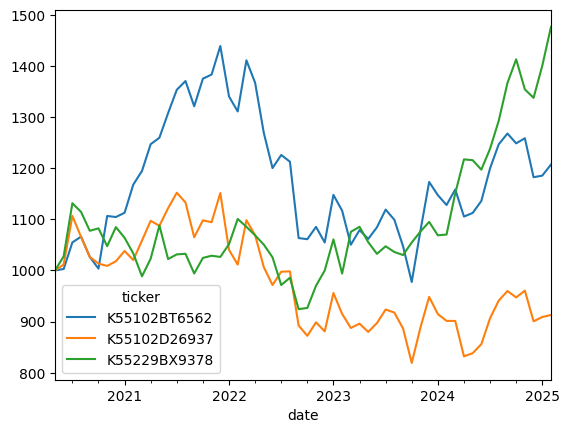

In [30]:
tickers = ['K55102BT6562', 'K55102D26937', 'K55229BX9378']

df_p = df_prc.loc[tickers].iloc[:,0].unstack(0)
start = df_p.apply(lambda x: x[x.notna()].index.min()).max()
normalized_df = df_p.apply(lambda x: x / x.loc[start] * base_prc).loc[start:]
normalized_df.plot()

## Testing

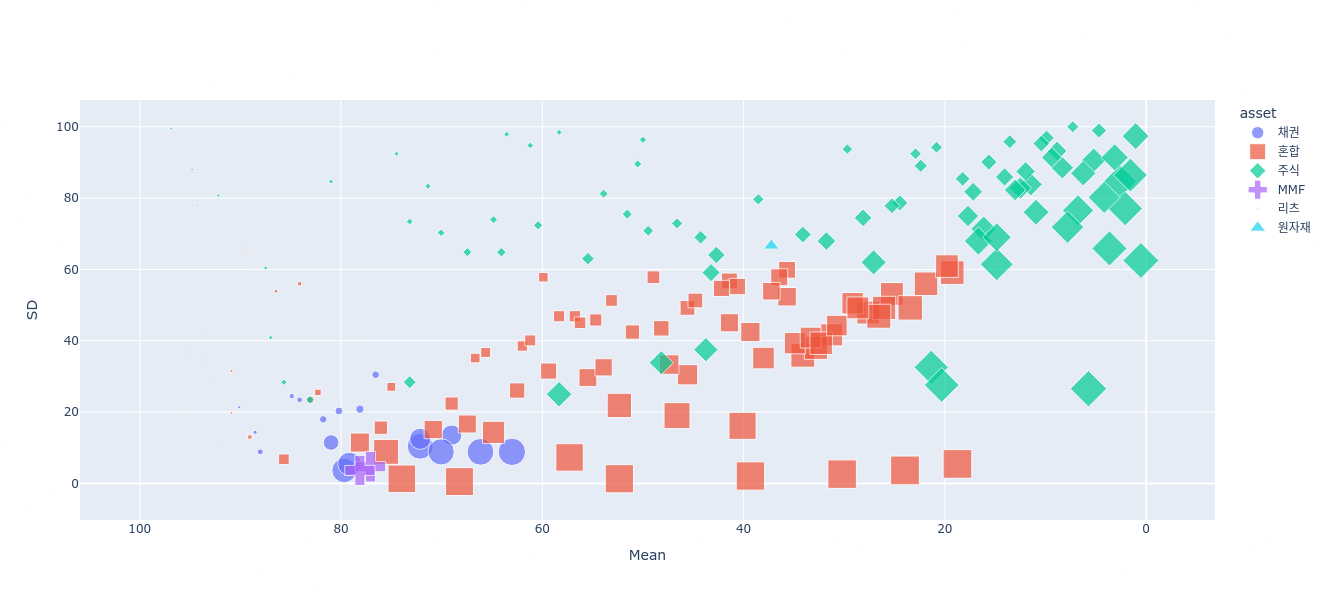

In [95]:
import plotly.graph_objects as go

category = 'asset'
scale_marker_size = 0.15

# Custom color map
color_map = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

# Get unique categories for color & symbol mapping
unique_categories = df[category].unique()
symbol_map = {cat: i for i, cat in enumerate(unique_categories)}

# Create traces for each category
traces = []
for i, cat in enumerate(unique_categories):
    df_filtered = df[df[category] == cat]
    
    trace = go.Scatter(
        x=df_filtered['mean'],
        y=df_filtered['sd'],
        customdata=df_filtered[['name', 'hdi_3%', 'hdi_97%']].values,
        mode='markers',
        marker=dict(
            #size=df_filtered['sharpe'].clip(upper=30),  # Set a max size for markers
            size=df_filtered['sharpe'] * scale_marker_size,
            color=color_map[i % len(color_map)],  # Assign a unique color per category
            symbol=symbol_map[cat]  # Assign a unique symbol per category
        ),
        name=cat,  # Legend entry
        hovertemplate=(
            "%{customdata[0]}<br>" +
            "수익률 순위(%): 평균 %{x:.0f}, 편차 %{y:.0f}<br>"
            "수익률 구간: %{customdata[1]} ~ %{customdata[2]}<extra></extra>"
        )
    )
    
    traces.append(trace)

# Define layout with reversed x-axis and set figure size
layout = go.Layout(
    xaxis=dict(title='Mean', autorange='reversed'),  # Reverse x-axis
    yaxis=dict(title='SD'),
    hovermode='closest',
    legend=dict(title=category),
    width=1000,  # Set figure width
    height=600  # Set figure height
)

# Create and show figure
fig = go.Figure(data=traces, layout=layout)
fig.show()


In [150]:
df.index

Index(['KR5101888398', 'KR5370AP9956', 'KR5236AS4826', 'K55105BH1010',
       'K55301BM7640', 'K55301BM7731', 'K55301BM8051', 'K55301BM7459',
       'K55223BT1450', 'K55105BS5067',
       ...
       'KR5235A52578', 'KR5235AK9691', 'KR5235AK9774', 'KR5235AK9808',
       'KR5301AK5995', 'KR5301AK6274', 'KR5301AL4401', 'KR5301AT1938',
       'KR5301AT1987', 'KR5364AH9467'],
      dtype='object', length=192)

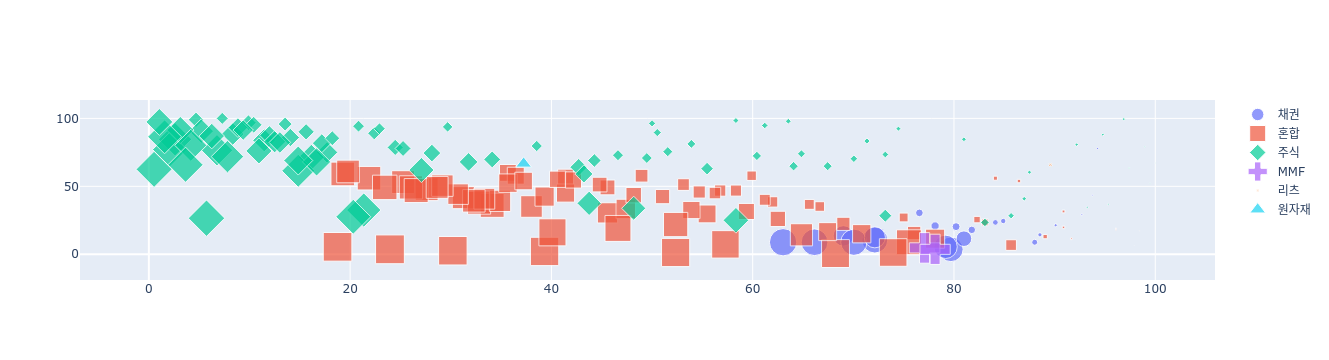

In [147]:

# ['name', 'seller', 'account', 'manager', 'asset', 'strategy', 'region']
category = 'asset'


import plotly.graph_objects as go

scale_marker_size = 0.15

# Custom color map
color_map = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

# Get unique categories for color & symbol mapping
unique_categories = df[category].unique()
symbol_map = {cat: i for i, cat in enumerate(unique_categories)}

# Create traces for each category
traces = []
for i, cat in enumerate(unique_categories):
    df_filtered = df[df[category] == cat]
    
    trace = go.Scatter(
        x=df_filtered['mean'],
        y=df_filtered['sd'],
        mode='markers',
        marker=dict(
            size=df_filtered['sharpe'] * scale_marker_size,
            color=color_map[i % len(color_map)],  # Assign a unique color per category
            symbol=symbol_map[cat]  # Assign a unique symbol per category
        ),
        name=cat,  # Legend entry
    )
    
    traces.append(trace)

# Create and show figure
fig = go.Figure(data=traces)
fig.show()

## Samples

### Callback

In [ ]:
import pandas as pd
import plotly.express as px
from dash import Dash, html, dcc, callback, Input, Output
from io import StringIO

file_prc = 'fund_monthly_241229.csv'
path = '.'

# Load price data
df_prc = pd.read_csv(
    f'{path}/{file_prc}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['group', 'ticker', 'date']
)

app = Dash(__name__)
app.layout = html.Div([
    html.Button('Submit', id='submit-val', n_clicks=0),
    dcc.Graph(id='price-plot'),
    dcc.Store(id='price-data'),
])

group_value = 2030
col = 'price'
df_p = df_prc.loc[group_value, col].unstack('ticker').sort_index()

@callback(
    Output(component_id='price-data', component_property='data'),
    Input(component_id='submit-val', component_property='n_clicks')
)
def update(n_clicks):
    return df_p.to_json(date_format='iso', orient='split')


@callback(
    Output(component_id='price-plot', component_property='figure'),
    Input(component_id='price-data', component_property='data')
)
def plot(data):
    # Use StringIO to wrap the string data
    data_io = StringIO(data)
    df = pd.read_json(data_io, orient='split')
    return px.line(df)

if __name__ == '__main__':
    app.run_server(debug=True)

### Clientside

In [ ]:
import pandas as pd
import plotly.express as px
from dash import Dash, html, dcc
import json

file_prc = 'fund_monthly_241229.csv'
path = '.'

# Load price data
df_prc = pd.read_csv(
    f'{path}/{file_prc}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['group', 'ticker', 'date']
)

app = Dash(__name__)

group_value = 2030
col = 'price'
df_p = df_prc.loc[group_value, col].unstack('ticker').sort_index()

# Preprocess the data and serialize it to JSON
preprocessed_data = df_p.to_json(date_format='iso', orient='split')

app.layout = html.Div([
    dcc.Graph(id='price-plot'),
    # Embed the preprocessed data as a hidden div or dcc.Store
    dcc.Store(id='price-data', data=preprocessed_data),
])

# Clientside callback for plotting
app.clientside_callback(
    """
    function(data) {
        if (!data) {
            return {'data': [], 'layout': {}};
        }
        // Parse the JSON data
        const df = JSON.parse(data);
        const dates = df.index;
        const columns = df.columns;

        const traces = columns.map((col, i) => ({
            x: dates,
            y: df.data.map(row => row[i]),
            mode: 'lines',
            name: col
        }));

        return {
            data: traces,
            layout: {
                title: 'Price Plot',
                xaxis: {title: 'Date'},
                yaxis: {title: 'Price'}
            }
        };
    }
    """,
    Output('price-plot', 'figure'),
    Input('price-data', 'data')
)

if __name__ == '__main__':
    app.run_server(debug=True)


### Mobile

In [ ]:
import pandas as pd
from dash import Dash, html, dcc
import dash_bootstrap_components as dbc
import json

file_prc = 'fund_monthly_241229.csv'
path = '.'

# Load price data
df_prc = pd.read_csv(
    f'{path}/{file_prc}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['group', 'ticker', 'date']
)

app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

group_value = 2030
col = 'price'
df_p = df_prc.loc[group_value, col].unstack('ticker').sort_index()

# Preprocess the data and serialize it to JSON
preprocessed_data = df_p.to_json(date_format='iso', orient='split')

app.layout = dbc.Container(
    [
        dbc.Row(
            dbc.Col(
                html.Button('Submit', id='submit-val', n_clicks=0),
                width={"size": 6, "offset": 3},  # Centered on the screen
                className="text-center"
            )
        ),
        dbc.Row(
            dbc.Col(
                dcc.Graph(id='price-plot'),
                width=12  # Full-width on all screen sizes
            ),
            className="mt-4"  # Add margin-top for spacing
        ),
        # Store the preprocessed data
        dcc.Store(id='price-data', data=preprocessed_data),
    ],
    fluid=True  # Full-width container
)

# Clientside callback for plotting
app.clientside_callback(
    """
    function(data) {
        if (!data) {
            return {'data': [], 'layout': {}};
        }
        // Parse the JSON data
        const df = JSON.parse(data);
        const dates = df.index;
        const columns = df.columns;

        const traces = columns.map((col, i) => ({
            x: dates,
            y: df.data.map(row => row[i]),
            mode: 'lines',
            name: col
        }));

        return {
            data: traces,
            layout: {
                title: 'Price Plot',
                xaxis: {title: 'Date'},
                yaxis: {title: 'Price'},
                margin: {l: 40, r: 10, t: 40, b: 40},
                responsive: true
            }
        };
    }
    """,
    Output('price-plot', 'figure'),
    Input('price-data', 'data')
)

if __name__ == '__main__':
    app.run_server(debug=True)


## testing

In [16]:
from dash import Dash, html, dcc, Output, Input, State
import pandas as pd
import dash_bootstrap_components as dbc
import dash_daq as daq
import json
from ddf_utils import break_line, extract_topics
from contents_info import info
from contents_topic_250204 import topics, images

external_stylesheets = [dbc.themes.CERULEAN, 
                        #dbc.themes.BOOTSTRAP,
                        dbc.icons.FONT_AWESOME,
                        dbc.icons.BOOTSTRAP]

style_heading={'color':'slategray', 'font-weight':'bold'}

default_group = '자산'
base_prc = 1000
date_format = '%Y-%m-%d'
months_in_year = 12
cols_prc = {
    'price': '수수료 적용 전', 
    'price_after_fees': '수수료 적용 후'
}
category = {
    'name': '펀드',
    'seller': '판매',
    'account': '계좌',
    'manager': '운용',
    'asset': '자산',
    'strategy': '전략',
    'region': '지역'
}

# data to import
dt = '250228'
file_prc = f'funds_monthly_{dt}.csv'
file_cat = 'funds_categories.csv'
file_est = 'funds_bayesian_ret3y_250228.csv'
path = '.'

# Load data
## price
df_prc = pd.read_csv(
    f'{path}/{file_prc}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['ticker', 'date']
)
df_prc.columns = [cols_prc[x] for x in df_prc.columns]

## cateory
df_cat = pd.read_csv(f'{path}/{file_cat}', index_col=['ticker'])

## beysian stats
df_est = pd.read_csv(f'{path}/{file_est}', index_col=['ticker'])

# Preprocess data to JSON-serializable
## category
data_cat = dict()
for col in df_cat.columns:
    data_cat[col] = df_cat[col].reset_index().groupby(col)['ticker'].apply(list).to_dict()

## name for plots
data_name = df_cat['name'].to_dict()

## price
data_prc = {}
for col in df_prc.columns:
    df = df_prc[col].unstack('ticker').sort_index().dropna(how='all')
    df = df.reindex(df.index.strftime(date_format))
    data_prc[col] = {x: df[x].dropna().to_dict() for x in df.columns}
    #data_prc[col] = df.to_dict(orient='dict')

## Scatter of estimations
xlabel, ylabel = 'mean', 'sd'
df_s = df_est.apply(lambda x: x[xlabel]/ x[ylabel], axis=1).rank().rename('sharpe')
data_est = df_est.join(df_s).join(df_cat)
# convert mean/sd into respective ranks
data_est[xlabel] = data_est[xlabel].rank(ascending=False, pct=True).mul(100)
data_est[ylabel] = data_est[ylabel].rank(pct=True).mul(100)
cols = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'sharpe'] + df_cat.columns.to_list()
data_est = data_est[cols].to_dict()

## rank
data_rank = df_est['mean'].rank(ascending=False).to_dict()

# define dropdown options and default value
category_options = [{'label':category[x], 'value':x} for x in df_cat.columns]
category_default = 'asset'
group_default = []

In [19]:
data_cat_json = json.dumps(data_cat)
data_name_json = json.dumps(data_name)
data_prc_json = json.dumps(data_prc)
data_est_json = json.dumps(data_est)
data_rank_json = json.dumps(data_rank)
data_title_json = json.dumps(data_title)

app = Dash(__name__, title="달달펀드",
           external_stylesheets=external_stylesheets)

app.index_string = f"""
<!DOCTYPE html>
<html>
    <head>
        {{%metas%}}
        <title>{{%title%}}</title>
        <link rel="icon" type="image/x-icon" href="/assets/favicon.ico">
        {{%css%}}
    </head>
    <body>
        <script>
            var dataCategory = {data_cat_json};
            var dataName = {data_name_json};
            var dataPrice = {data_prc_json};
            var dataScatter = {data_est_json};
            var dataRank = {data_rank_json};
            var dataTitle = {data_title_json};
        </script>
        {{%app_entry%}}
        {{%config%}}
        {{%scripts%}}
        {{%renderer%}}
    </body>
</html>
"""

# footer
footer = html.Footer(
    html.Small([
    html.I(className="fa-regular fa-copyright"),
    '2025 달달펀드'
]), style={'textAlign': 'right', 'margin-top': '20px'})

# info
tab_info = html.Div([
    html.P(),
    html.P('다달이 전하는 펀드 투자 정보', style=style_heading),
    html.Div(break_line(info['about'], html.P), style={'line-height': '100%'}),
    html.Div([
        dbc.Alert([
            html.I(className="bi bi-info-circle-fill me-2"),
            info['disclaimer'],
            ],
            color="info",
            className="d-flex align-items-center",
        ),
        html.P([
            html.I(className="fa-regular fa-envelope", title='문의', style={"margin-right": "10px"}),
            html.A(info['email'], href=f"mailto:{info['email']}?Subject=달달펀드:문의")
        ], style={'textAlign': 'right'})
    ], style={'fontSize': 14})
    #])
])

# tabs
tabs_contents = [
    dbc.Tab(dcc.Graph(id='price-plot'), label='가격'),
    dbc.Tab(dcc.Graph(id='cagr-plot'), label='수익률', tab_id='tab_cagr'),
    dbc.Tab(dcc.Graph(id='scatter-plot'), label='순위', tab_id='tab_scatter'),
    dbc.Tab(tab_info, label='정보', tab_id='tab_info')
]
tabs = dbc.Tabs(tabs_contents, id='tabs')


app.layout = dbc.Container([
    html.Br(),
    dbc.Stack([
        html.Div(
            dcc.Dropdown(
                id='category-dropdown',
                options=category_options,
                value=category_default,
                clearable=False,
            ), style={'min-width':'10%', 'max-width':'100%'}
        ),
        html.Div(
            dcc.Dropdown(
                id='group-dropdown',
                #options=groups,
                value=group_default,
                multi=True,
            ), style={'min-width':'30%', 'max-width':'100%'}
        ),
        daq.BooleanSwitch(
            id='compare-boolean-switch',
            on=False
        ),
        daq.BooleanSwitch(
            id='cost-boolean-switch',
            on=False
        ),
        dcc.Clipboard(
            id='ticker-copy',
            target_id="ticker-textarea",
            style={
                "display": "inline-block",
                "fontSize": 25,
                "color": "darkgray",  # Default icon color
                "cursor": "pointer",  # Pointer cursor for better UX
                #"verticalAlign": "bottom",
            },
        ),
    ],
        #justify="start", # horizondal
        #align="center", # vertical
        direction="horizontal",
        gap=2,
        className="mb-3"
    ),
    dbc.Row(tabs),
    dbc.Row(footer),
    html.Br(),
    dcc.Textarea(
        id="ticker-textarea",
        hidden='hidden', 
        #cols=50, rows=10
    ),
    dbc.Tooltip(
        '상대 비교',
        target='compare-boolean-switch',
        placement='bottom'
    ),
    dbc.Tooltip(
        '수수료 적용',
        target='cost-boolean-switch',
        placement='bottom'
    ),
    dbc.Tooltip(
        '펀드코드 복사',
        target='ticker-copy',
        placement='bottom'
    ),
    dcc.Store(id='ticker-data'),
    dcc.Store(id='name-data'),
    dcc.Store(id='price-data'),
    dcc.Store(id='scatter-data'),
    dcc.Location(id="url", refresh=False),  # To initialize the page
#], fluid=True)  # Full-width container
])

# update group options depending on category
app.clientside_callback(
    """
    function(category) {
        let obj = dataCategory[category];
        let groups = Object.keys(obj);
        let maxLength = 20; // Set max label length

        // Prepend "All" to the list
        let options = [
            { label: "All", value: "All", title: "All" },
            { label: "#Top10", value: "#Top10", title: "#Top10"},
            { label: "#Bottom10", value: "#Bottom10", title: "#Bottom10"},
            { label: "#Random10", value: "#Random10", title: "#Random10"},
        ];

        // Map over groups and append them to the list
        options = options.concat(
            groups.map(group => ({
                label: group.length > maxLength ? group.substring(0, maxLength) + "..." : group,
                value: group,
                title: dataTitle[group] || group  // Use group name if dataTitle[group] is missing
            }))
        );
        return [options, ['All', '#Top10']];
    }
    """,
    Output('group-dropdown', 'options'),
    Output('group-dropdown', 'value'),
    Input('category-dropdown', 'value')
)

# check group values with 'All' or ranking
app.clientside_callback(
    """
    function processGroups(groups) {
        // Split groups into `groups_m` (regular) and `groups_opt` (options)
        let { groups_m, group_opt } = groups.reduce((acc, group) => {
            if (group.startsWith("#")) {
                acc.group_opt = group; // Keep only the latest rank option
            } else {
                acc.groups_m.push(group);
            }
            return acc;
        }, { groups_m: [], group_opt: null });

        // Check if 'All' is the last element
        if (groups_m.length === 0 || groups_m[groups_m.length - 1] === 'All') {
            return ['All', group_opt].filter(Boolean); // Remove null values
        };
    
        // If 'All' is in the array but not the last element, return without 'All'
        if (groups_m.includes('All')) {
            return groups_m.filter(group => group !== 'All').concat(group_opt);
        };
        
        // Otherwise, return the array with new rank option
        return groups_m.concat(group_opt);
    }
    """,
    Output('group-dropdown', 'value', allow_duplicate=True),
    Input('group-dropdown', 'value'),
    prevent_initial_call=True
)

# update tickers based on selected groups and category
app.clientside_callback(
    """
    function(groups, category) {
        let tickers = [];
        if (!groups || !category || !dataCategory[category]) return tickers;

        // If groups contain "All", return all tickers from the category
        if (groups.includes("All")) {
            tickers = Object.values(dataCategory[category]).flat();
        } else {
            // Otherwise, return tickers only for the specified groups
            groups.forEach(group => {
                if (dataCategory[category] && dataCategory[category][group]) {
                    tickers = tickers.concat(dataCategory[category][group]);
                }
            });
        };

        // filter tickers depending on the order in dataRank
        let groups_opt = groups.filter(group => group.startsWith('#'))
        if (groups_opt.length === 1) {
            const match = groups_opt[0].slice(1).match(/^([a-zA-Z]+)(\\d+)$/);
            tickers = selectTickers(match[1], tickers, dataRank, num=match[2])
            //tickers = selectTickers("Top", tickers, dataRank, num=10)
        };
        return tickers;
    }
    """,
    Output('ticker-data', 'data'),
    Input('group-dropdown', 'value'),
    State('category-dropdown', 'value')
)

# save name and ticker of funds for copying
app.clientside_callback(
    """
    function(tickers) {
        let result = Object.entries(dataName)
                     .filter(([k, v]) => tickers.includes(k)) // check if k is in tickers
                     .map(([k, v]) => `${k}: ${v}`);
        return result.join('\\n');
    }
    """,
    Output('ticker-textarea', 'value'),
    Input('ticker-data', 'data'),
)

# update price data based on selected tickers
app.clientside_callback(
    """
    function(tickers) {
        if (!tickers || tickers.length === 0) return {};
        
        let data_prc_tkr = {};
        for (let fee in dataPrice) {
            data_prc_tkr[fee] = {};
            for (let tkr in dataPrice[fee]) {
                if (tickers.includes(tkr)) {
                    data_prc_tkr[fee][tkr] = dataPrice[fee][tkr];
                }
            }
        }
        return data_prc_tkr;
    }
    """,
    Output('price-data', 'data'),
    Input('ticker-data', 'data')
)

# plot price history
app.clientside_callback(
    """
    function(data, cost, compare) {
        if (!data || Object.keys(data).length === 0) {
            return { data: [], layout: {} };  // Empty plot
        }
        
        let fees = Object.keys(data);
        let fee = cost ? fees[1] : fees[0];

        if (!data[fee]) {
            return { data: [], layout: {} };
        }

        let df = data[fee];
        if (compare) {
            df = normalizePrice(df, 1000);
        }
        let traces = [];

        for (let tkr in df) {
            traces.push({
                x: Object.keys(df[tkr]),  // Assuming keys are dates
                y: Object.values(df[tkr]),  // Assuming values are prices
                type: 'scatter',
                mode: 'lines',
                name: dataName[tkr]
            });
        }

        // Title logic
        const titleBase = '펀드 가격 추이';
        const titleComp = compare ? '상대 가격' : '펀드별 최근 결산 기준가격';
        const titleCost = cost ? '수수료 적용' : null;

        let title = `${titleBase} (${titleComp}`;
        title = titleCost ? `${title}, ${titleCost})` : `${title})`;
        
        return {
            data: traces,
            layout: {
                title: { text: title},
                hovermode: 'x',
                yaxis: { title: '가격' },
                xaxis: {
                    rangeselector: {
                        buttons: [
                            {
                                count: 3,
                                label: "3y",
                                step: "year",
                                stepmode: "backward"
                            },
                            {
                                step: "all",
                                label: "All"
                            }
                        ]
                    },
                    type: "date"
                },
            }
        };
    }
    """,
    Output('price-plot', 'figure'),
    Input('price-data', 'data'),
    Input('cost-boolean-switch', 'on'),
    Input('compare-boolean-switch', 'on'),
)


# plot bar chart of cagr
app.clientside_callback(
    """
    function(data, compare) {
        if (!data || Object.keys(data).length === 0) {
            return { data: [], layout: {} };
        }

        // calc CAGR
        let data_cagr = {};
        for (let fee in data) {
            let df = data[fee];
            if (compare) { // normalize depending on compare switch
                df = normalizePrice(df, 1000);
                let tickers = Object.keys(df);
                var dates = Object.keys(df[tickers[0]]);
                console.log(dates)
            };
            data_cagr[fee] = {};
            for (let tkr in df) {
                data_cagr[fee][tkr] = calculateCAGR(df[tkr]);
            }
        }

        let categories = Object.keys(data_cagr);
        let tickers = Object.keys(data_cagr[categories[0]]);
        
        let traces = categories.map(category => {
            return {
                x: tickers.map(tkr => dataName[tkr]),
                y: tickers.map(tkr => data_cagr[category][tkr] || 0),
                type: 'bar',
                name: category
            };
        });

        let title;
        if (compare) {
            const dt0 = new Date(Math.min(...dates.map(d => new Date(d).getTime()))).toISOString().slice(0, 10);
            const dt1 = new Date(Math.max(...dates.map(d => new Date(d).getTime()))).toISOString().slice(0, 10);
            title = `펀드 연평균 수익률 (${dt0} ~ ${dt1})`;
        } else {
            title = '펀드 연평균 수익률 (펀드별 설정일 이후)';
        };

        let layout = {
            title: {text: title},
            barmode: 'group',
            hovermode: 'x',
            //xaxis: { title: 'Ticker' },
            yaxis: { title: '연평균 수익률 (%)' }
        };

        return { data: traces, layout: layout };
    }
    """,
    Output('cagr-plot', 'figure'),
    Input('price-data', 'data'),
    Input('compare-boolean-switch', 'on')
)

# update scatter data based on selected tickers
app.clientside_callback(
    """
    function(tickers) {
        if (!tickers || tickers.length === 0) return {};

        const filteredData = {};
        for (const key in dataScatter) {
            filteredData[key] = {};
            for (const ticker of tickers) {
              if (dataScatter[key][ticker] !== undefined) {
                filteredData[key][ticker] = dataScatter[key][ticker];
              }
            }
        }
        
        return filteredData;
    }
    """,
    Output('scatter-data', 'data'),
    Input('ticker-data', 'data')
)

# scatter plot of mean/sd of 3yr return estimations
app.clientside_callback(
    """
    function(data, category) {
        // Define the scale for marker size
        const scale_marker_size = 0.1;
        const add_marker_size = 5;
        
        // Custom color map
        const color_map = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52'];

        // Get the keys (i.e., the unique identifiers) for the data
        const keys = Object.keys(data['mean']);

        // Filter the unique categories based on the selected category
        const unique_categories = [...new Set(keys.map(key => data[category][key]))];

        // Create a map for symbols to be assigned to each category
        const symbol_map = {};
        unique_categories.forEach((cat, i) => {
            symbol_map[cat] = i;
        });

        // Create traces for each category
        let traces = unique_categories.map((cat, i) => {
            // Filter data by the selected category
            const df_filtered = keys.filter(key => data[category][key] === cat);

            // Create the trace for each category
            return {
                x: df_filtered.map(key => data['mean'][key]),
                y: df_filtered.map(key => data['sd'][key]),
                customdata: df_filtered.map(key => [
                    data['name'][key], 
                    data['hdi_3%'][key], 
                    data['hdi_97%'][key]
                ]),
                mode: 'markers',
                marker: {
                    size: df_filtered.map(key => data['sharpe'][key] * scale_marker_size + add_marker_size),
                    color: color_map[i % color_map.length],  // Assign a unique color per category
                    symbol: df_filtered.map(key => symbol_map[data[category][key]])  // Assign a unique symbol per category
                },
                name: cat,  // Legend entry
                hovertemplate: '<span style=\"font-size: 120%;\">%{customdata[0]}</span><br>' +
                               '수익률 순위(%): 평균 %{x:.0f}, 편차 %{y:.0f}<br>' +
                               '수익률 구간: %{customdata[1]} ~ %{customdata[2]}<extra></extra>',
            };
        });

        // Define layout
        let layout = {
            title: { text: '펀드 순위 (3년 수익률의 94% 확률 추정)' }, 
            xaxis: { title: '평균 %순위', autorange: 'reversed', zeroline:false },
            yaxis: { title: '편차 %순위', autorange: 'reversed', zeroline:false },
            hovermode: 'closest',
            showlegend: true,
            legend: { title: category },
            //width: 1000,
            //height: 600,
        };

        // Return the data for the figure
        return { data: traces, layout: layout };
    }
    """,
    Output('scatter-plot', 'figure'),
    Input('scatter-data', 'data'),
    Input('category-dropdown', 'value')
);

# contrain fee/compare switch depending on tabs
app.clientside_callback(
    """
    function(tab, cost, compare) {
        if (tab === "tab_scatter") {
            return [true, false, true, true];
        } else if (tab === "tab_info") {
            return [cost, compare, true, true];
        } else if (tab === "tab_cagr") {
            return [true, compare, true, false];
        } else {
            return [cost, compare, false, false];
        }
    }
    """,
    [Output('cost-boolean-switch', 'on'), Output('compare-boolean-switch', 'on'), 
     Output('cost-boolean-switch', 'disabled'), Output('compare-boolean-switch', 'disabled')],
    [Input("tabs", "active_tab"), Input('cost-boolean-switch', 'on'), Input('compare-boolean-switch', 'on')]
)

# contrain category/group dropdown depending on tabs
app.clientside_callback(
    """
    function(tab, category, group) {
        if (tab === "tab_info") {
            return [true, true];
        } else {
            return [false, false];
        }
    }
    """,
    Output('category-dropdown', 'disabled'), 
    Output('group-dropdown', 'disabled'),
    Input("tabs", "active_tab")
)

## testing

## testing

In [ ]:
import pandas as pd

In [ ]:
file = 'fund_name_241230.csv'
path = '.'

fund_name = pd.read_csv(f'{path}/{file}', dtype={'ticker': str}, index_col=[0])
fund_name = fund_name.iloc[:,0].to_dict()
fund_name

In [ ]:
import re


m = re.search(r'\d{4}', s)
func = lambda s: [s if x is None else s[:x.end()] for x in [re.search(r'\d{4}', s)]][0]

In [ ]:
s = '신한마음편한TDF2040증권투자신탁[주식혼합-재간접형](종류C-re)'
#s = '신한마음편한TDF증권투자신탁[주식혼합-재간접형](종류C-re)'

func = lambda s: s[:m.end()] if (m := re.search(r'\d{4}', s)) else s

func(s)

In [ ]:
#i = 2050
i = 2055
data = preprocessed_data[i]
#data.keys()

col = '수수료 적용 전'
d = data['default'][col]['history']
i = data['default'][col]['index']
df = pd.DataFrame(d, index=i)

import plotly.express as px
px.line(df)

In [ ]:
import plotly.graph_objects as go

i = 2050
data = preprocessed_data[i]
#data.keys()

col = '수수료 적용 전'
d = data['default'][col]['history']
i = data['default'][col]['index']

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=i, y=d,
                    mode='lines',
                    #name='ticker'
                        )
             )
fig.show()

In [ ]:
# You can use Plotly's `plot` function to visualize the result
import plotly.offline as pyo
pyo.plot(result)

In [ ]:
d

In [ ]:
"""
            return {
                x: dat.index,        // Dates from the index
                y: yValues,          // Price history for each ticker
                type: 'scatter',
                mode: 'lines',
                name: ticker,        // Ticker as the legend name
                //color: ticker
            };
            """

In [ ]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np
np.random.seed(1)

N = 100
random_x = np.linspace(0, 1, N)
random_y0 = np.random.randn(N) + 5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N) - 5

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                    mode='markers',
                    name='markers'))


"""
            return {
                x: dat.index,        // Dates from the index
                y: yValues,          // Price history for each ticker
                type: 'scatter',
                mode: 'lines',
                name: ticker,        // Ticker as the legend name
                //color: ticker
            };
            """

In [ ]:
import plotly.graph_objects as go
import pandas as pd

data= pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/2014_usa_states.csv")

fig = go.Figure(data=go.Scatter(x=data['Postal'],
                                y=data['Population'],
                                mode='markers',
                                marker_color=data['Population'],
                                text=data['State'])) # hover text goes here

fig.update_layout(title=dict(text='Population of USA States'))
fig.show()

In [ ]:
import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada', color='country')
fig.show()

In [ ]:
df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df, x="year", y="lifeExp", color='country')
fig.show()